# La transformation vmap

In [8]:
import jax.numpy as jnp
import jax
from jax import grad, jit, vmap
from jax import random as jr
import matplotlib.pyplot as plt
import numpy as np

## qu'est-ce qu'une transformation

'Transformation' c'est le terme pour une fonction qui prend en entrée une fonction et return une autre fonction.

In [9]:
def fn_of_x_to_fn_of_2x(fn):
    ...

fn_of_x = lambda x: x**2
fn_of_2x = fn_of_x_to_fn_of_2x(fn_of_x)
fn_of_2x(3)

In [9]:
#--- To keep following outputs, do not run this cell! ---

36

Le décorateur `@`: une autre manière d'appliquer une transformation

In [10]:
@fn_of_x_to_fn_of_2x
def fn(x):
    return x**2

fn(3)

***A vous:*** Sur le plot ci-dessous, qui est `fn_of_x`, qui est `fn_of_2x`. Faites votre propre raisonnement pour ne jamais vous tromper.


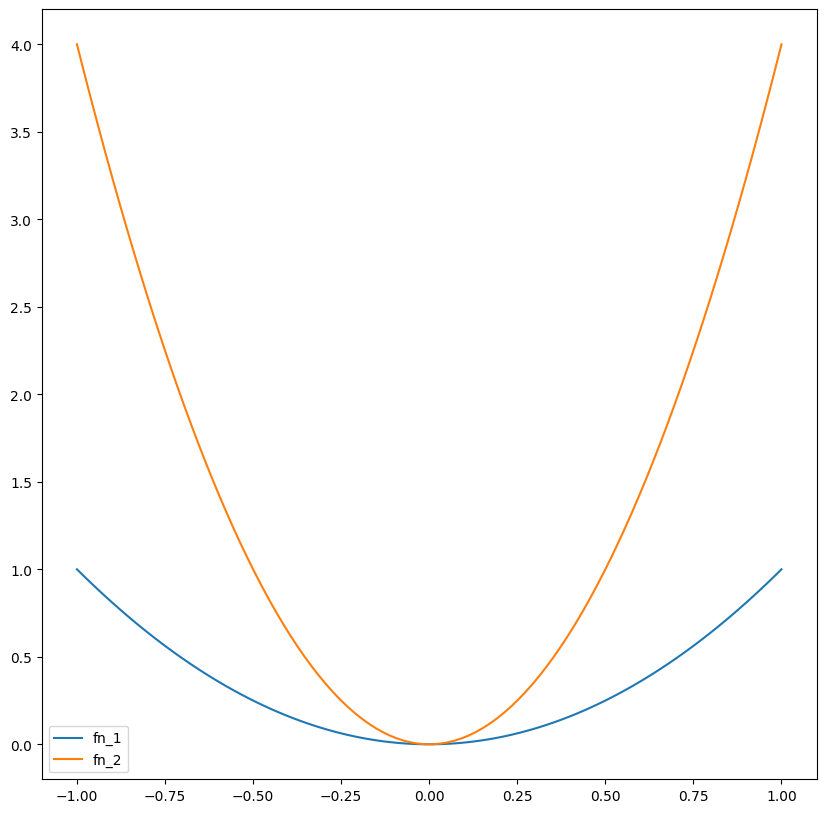

In [11]:
#--- To keep following outputs, do not run this cell! ---

## vmap sur tous les arguments

In [12]:
def fn_of_x_y(x,y):
    return x[0]*y[0]+x[0]*y[1]+x[1]*y[0]

x=jnp.array([1,2])
y=jnp.array([3,4])
fn_of_x_y(x,y)

In [13]:
fn_of_xV_yV = vmap(fn_of_x_y)

batch_size = 7
xV = jnp.ones([batch_size,2])
yV = jnp.ones([batch_size,2])



## En précisant les arguments


Tout à l'heure:

    fn_of_xV_yV = vmap(fn_of_x_y)

Etait l'équivalent de

    fn_of_xV_yV = vmap(fn_of_x_y,[0,0])


⇑ ci-dessus la paire `[0,0]` indique que l'on a ajouter un indice `i` (=0) au deux argument.

Mathématiquement on est passé d'une fonction
$$
\mathbb R^2\times \mathbb R^2  \to \mathbb R
$$
 à une fonction
 $$
 \mathbb R^{b\times 2}\times \mathbb R^{b\times 2} \to \mathbb R^b
 $$
  où $b$ est le fameux `batch_size`.

Mais souvent, on veut vmaper que sur un seul argument

In [14]:
def U_of_θ_inp(θ,inp):
    return θ[0] + θ[1]*inp

θ = jnp.array([1.,2])
inp_dim = 2
inp = jnp.ones([inp_dim])

U_of_θ_inp(θ,inp)

In [15]:
U_of_θ_inpV = vmap(U_of_θ_inp,[None,0])

batch_size = 7

inpV = jnp.ones([batch_size,inp_dim])

U_of_θ_inpV(θ,inpV)

⇑ Mathématiquement on est passé d'une fonction
$$
\mathbb R^2\times \mathbb R^2  \to \mathbb R^2
$$
 à une fonction
 $$
 \mathbb R^{2}\times \mathbb R^{b\times 2} \to \mathbb R^{b\times 2}
 $$

## Double vmap

### Pour croiser des indices

A l'ancienne

In [16]:
a=jnp.arange(5)
b=jnp.arange(7)
c=jnp.arange(7)

#M_ij = a_i * b_j * c_j
M=a[:,None] * b[None,:] * c[None,:]
M.shape

Avec un double vmap:

In [17]:
def multiply(a,b,c):
    return a*b*c

multiply_v = vmap(vmap(multiply,[None,0,0]),[0,None,None])
M_=multiply_v(a,b,c)
M_.shape

In [18]:
jnp.allclose(M,M_)

⇑ Mathématiquement, avec le premier `vmap` on est passé d'une fonction
$$
\mathbb R \times \mathbb R  \times \mathbb R  \to \mathbb R
$$
 à une fonction
$$
\mathbb R \times \mathbb R^J  \times \mathbb R^J  \to \mathbb R^J
$$
où $J=5$ est la dimension des vecteur `b` et `c`. Puis avec le second `vmap` on est passé de la fonction d'avant à  une fonction
$$
\mathbb R^I \times \mathbb R^{ J}  \times \mathbb R^{ J}  \to \mathbb R^{I\times J}
$$
où $I=7$ est la dimension du vecteur `a`.

### Application pour des tracés en niveau de couleurs


Avec un double `vmap` total. On transforme une fonction sur les scalaires en une fonction sur les matrices.

In [19]:
def U_fn(x,y):
    return x * jnp.sin(20*y)

x = jnp.linspace(-1,1,100)
y = jnp.linspace(-1,1,100)


x_mat,y_mat = jnp.meshgrid(x,y,indexing="ij")

U_mat = vmap(vmap(U_fn))(x_mat,y_mat)
U_mat.shape

⇑ Mathématiquement, avec le premier `vmap` on est passé d'une fonction scalaire à une foncion
$$
\mathbb R^J \times \mathbb R^J \to \mathbb R^{J}
$$
Puis avec le second on passe à:
$$
\mathbb R^{I\times J} \times \mathbb R^{I\times J} \to \mathbb R^{I\times J}
$$

In [20]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.pcolormesh(x_mat,y_mat,U_mat)
plt.colorbar(ax.collections[0]);

Plus économique en mémoire. Avec 2 `vmap` partiels.

In [21]:
U_mat2 = vmap(vmap(U_fn,[None,0]),[0,None])(x,y)
U_mat2.shape

⇑ Premier `vmap`, la fonction scalaire devient
$$
\mathbb R \times \mathbb R^J \to \mathbb R^J
$$
où $J$ est la dimension du second argument `y`.

Second `vmap`, la fonction précédente devient:
$$
\mathbb R^I \times \mathbb R^J \to \mathbb R^{I\times J}
$$
où $I$ est la dimension du second argument `x`.


In [22]:
jnp.allclose(U_mat,U_mat2)

Perso j'utilise toujours `meshgrid` avec `indexing=ij`

Ainsi, dans `U_mat[i,j]` la variation en `x` porte sur l'indice `i`.

Pas de problème avec `pcolormesh`. Mais attention si on utilise `imshow` l'image est dans le mauvais sens:

In [23]:
plt.imshow(U_mat);

## Défi prog: mélange de cloche

In [24]:
np.random.seed(42)
nb_cloche=5
x=np.linspace(-1,11,300)
x_=x[None,:]
mu=np.random.uniform(1,9,size=[nb_cloche,1])
sigma=np.random.uniform(0.1,0.2,size=[nb_cloche,1])
gauss=np.exp(-0.5*(x_-mu)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma)
gauss.shape

In [25]:
fig,axs=plt.subplots(5,1,sharex="all",sharey="all")
for i in range(5):
    axs[i].


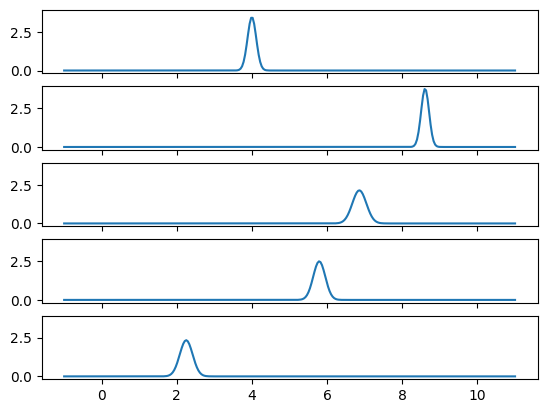

In [25]:
#--- To keep following outputs, do not run this cell! ---

In [26]:
melange=
plt.plot(x,melange);

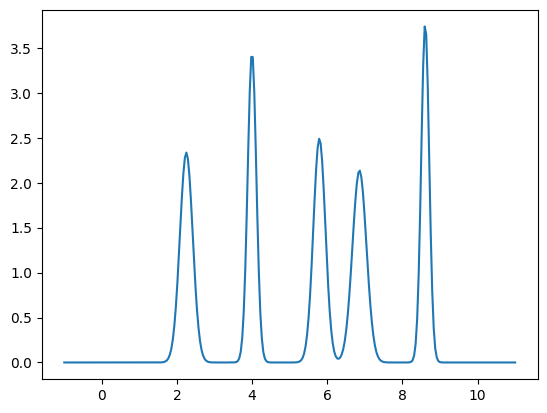

In [26]:
#--- To keep following outputs, do not run this cell! ---

***A vous:*** Refaites ce programme en pure jax. Utilisez vmap.

In [27]:
# Fonction non vectorisée:
def gauss_fn(x,mu,sigma):
    return jnp.exp(-0.5*(x-mu)**2/sigma**2)/(jnp.sqrt(2*jnp.pi)*sigma)

#Effectuons un double vmap:
gauss_fn_vmap==vmap(vmap(...


x=jnp.linspace(-1,11,300)

rk1,rk2=jr.split(jr.key(42))

mu=jr.uniform(rk1,nb_cloche,minval=1,maxval=9)
sigma=jr.uniform(rk2,nb_cloche,minval=0.1,maxval=0.2)


gauss=gauss_fn_vmap(x,mu,sigma)

gauss.shape

In [27]:
#--- To keep following outputs, do not run this cell! ---

(5, 300)

In [28]:
melange=
plt.plot(x,melange);

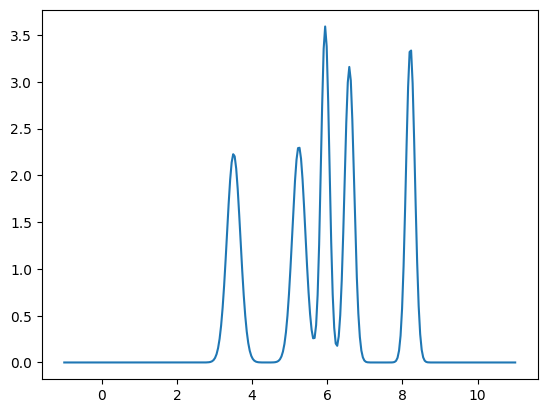

In [28]:
#--- To keep following outputs, do not run this cell! ---

Et comme on a souvent besoin d'un batch de mélange de cloche:

In [29]:
def melange_fn(x,mu,sigma):
    gauss=gauss_fn_vmap(x,mu,sigma)
    melange=jnp.sum(gauss,axis=0)
    return melange

melange_fn_vmap=vmap(

batch_size=7
x=jnp.linspace(-1,11,300)

rk1,rk2=jr.split(jr.key(42))

mu=jr.uniform(rk1,[batch_size,nb_cloche],minval=1,maxval=9)
sigma=jr.uniform(rk2,[batch_size,nb_cloche],minval=0.1,maxval=0.2)

melange=melange_fn_vmap(x,mu,sigma)
melange.shape

In [29]:
#--- To keep following outputs, do not run this cell! ---

(7, 300)

In [30]:
fig,axs=plt.subplots(batch_size,1,sharex="all",sharey="all")
for i in range(batch_size):
    axs[i].plot(x,melange[i,:])